In [ ]:
# 발음 전사 위한 pip
!pip install g2pk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 580.9/580.9 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 30.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# target 준비

In [ ]:
from g2pk import G2p

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [ ]:
from pathlib import Path
import re
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import json
import orjson

In [ ]:
# 1. 자모 리스트 정의
CHOSUNG_LIST = ['ㄱ','ㄲ','ㄴ','ㄷ','ㄸ','ㄹ','ㅁ','ㅂ','ㅃ','ㅅ','ㅆ',
                'ㅇ','ㅈ','ㅉ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ']
JUNGSUNG_LIST = ['ㅏ','ㅐ','ㅑ','ㅒ','ㅓ','ㅔ','ㅕ','ㅖ','ㅗ','ㅘ','ㅙ',
                 'ㅚ','ㅛ','ㅜ','ㅝ','ㅞ','ㅟ','ㅠ','ㅡ','ㅢ','ㅣ']
JONGSUNG_LIST = ['','ㄱ','ㄲ','ㄳ','ㄴ','ㄵ','ㄶ','ㄷ','ㄹ','ㄺ','ㄻ',
                 'ㄼ','ㄽ','ㄾ','ㄿ','ㅀ','ㅁ','ㅂ','ㅄ','ㅅ','ㅆ',
                 'ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ']
RESERVED = ["<pad>", "<sos>", "<eos>", " "]  # <pad> == <blank>

# 자모 인덱스 테이블 만들기
ALL_JAMOS = sorted(set(CHOSUNG_LIST + JUNGSUNG_LIST + JONGSUNG_LIST))
ALL_JAMOS.remove('')  # 종성의 공백 제거

ALL_JAMOS = RESERVED + ALL_JAMOS

# 자모 사전 만들기
jamo_to_index = {j: i for i, j in enumerate(ALL_JAMOS)}
index_to_jamo = {i: j for j, i in jamo_to_index.items()}

vocab_size = len(jamo_to_index)

# 2. 자모 분해 함수
def decompose_hangul(text):
    result = ["<sos>"]
    for char in text:
        if '가' <= char <= '힣':
            code = ord(char) - ord('가')
            cho = CHOSUNG_LIST[code // (21*28)]
            jung = JUNGSUNG_LIST[(code % (21*28)) // 28]
            jong = JONGSUNG_LIST[code % 28]
            result.extend([cho, jung])
            if jong != '':
                result.append(jong)
        else:
            result.append(char)
    result.append("<eos>")
    return result

# 3. 자모 복원 함수
import re

def compose_jamos(jamo_sequence):
    # <sos>, <eos> 제거
    seq = [j for j in jamo_sequence if j not in ("<sos>", "<eos>")]
    result = ''
    i = 0
    n = len(seq)

    while i < n:
        ch = seq[i] if i < n else ''
        ju = seq[i + 1] if i + 1 < n else ''
        # 규칙: (초성, 중성) 조합이 되는 경우만 한 글자 조립 시도
        if ch in CHOSUNG_LIST and ju in JUNGSUNG_LIST:
            use_jong = False
            jong = ''

            # 후보 종성(=세 번째 자모)이 있는 경우 판단
            if i + 2 < n:
                jo = seq[i + 2]
                if jo in JONGSUNG_LIST:
                    # jo가 '다음 글자 초성'으로도 사용 가능한 자모(예: ㄱ, ㄴ, ㄷ, ㅅ, ㅇ 등)이고
                    # jo 다음이 '모음'이면 -> jo는 다음 글자의 초성으로 사용 (종성 아님)
                    if (jo in CHOSUNG_LIST) and (i + 3 < n and seq[i + 3] in JUNGSUNG_LIST):
                        use_jong = False
                    else:
                        # 그 외의 경우(문장 끝, 공백, 다음이 자음 등) -> 종성으로 사용
                        use_jong = True
                        jong = jo

            if use_jong:
                code = 0xAC00 + (
                    CHOSUNG_LIST.index(ch) * 21 * 28 +
                    JUNGSUNG_LIST.index(ju) * 28 +
                    JONGSUNG_LIST.index(jong)
                )
                result += chr(code)
                i += 3
            else:
                code = 0xAC00 + (
                    CHOSUNG_LIST.index(ch) * 21 * 28 +
                    JUNGSUNG_LIST.index(ju) * 28
                )
                result += chr(code)
                i += 2
        else:
            # 조합 불가: 있는 그대로 출력
            result += ch
            i += 1

    return result

# 4. 전체 파이프라인
def text_to_ctc_indices(text):
    text = re.sub(r'[^가-힣 ]', '', text)
    g2p = G2p()
    pronounced = g2p(text)  # 발음 기반 변환

    jamo_seq = decompose_hangul(text)  # 자모 분해
    jamo_seq = jamo_seq[1:] if jamo_seq[0] == " " else jamo_seq
    jamo_seq = jamo_seq[:-1] if jamo_seq[-1] == " " else jamo_seq

    pron_jamo_seq = decompose_hangul(pronounced)  # 자모 분해
    pron_jamo_seq = pron_jamo_seq[1:] if pron_jamo_seq[0] == " " else pron_jamo_seq
    pron_jamo_seq = pron_jamo_seq[:-1] if pron_jamo_seq[-1] == " " else pron_jamo_seq

    indices = [jamo_to_index[j] for j in jamo_seq if j in jamo_to_index]  # 인덱싱
    pron_indices = [jamo_to_index[j] for j in pron_jamo_seq if j in jamo_to_index]  # 인덱싱

    compose = compose_jamos(jamo_seq)  # 복원
    pron_compose = compose_jamos(pron_jamo_seq)# 복원

    return text, pronounced, jamo_seq, pron_jamo_seq, indices, pron_indices, compose, pron_compose

# 5. 예시 실행
text = "숙주도 있어서 넣고 이것저것 해서"
text, pronounced, jamo_seq, pron_jamo_seq, indices, pron_indices, compose, pron_compose  = text_to_ctc_indices(text)

# 결과 출력
print("✅ 원문:", text)
print("✅ 원문 분해:", jamo_seq)
print("✅ 원문 시퀀스:",indices)
print("✅ 원문 복원:", compose)
print()
print("✅ 발음 표기:", pronounced)
print("✅ 발음 분해:", pron_jamo_seq)
print("✅ 발음 시퀀스:", pron_indices)
print("✅ 발음 복원:", pron_compose)

✅ 원문: 숙주도 있어서 넣고 이것저것 해서
✅ 원문 분해: ['<sos>', 'ㅅ', 'ㅜ', 'ㄱ', 'ㅈ', 'ㅜ', 'ㄷ', 'ㅗ', ' ', 'ㅇ', 'ㅣ', 'ㅆ', 'ㅇ', 'ㅓ', 'ㅅ', 'ㅓ', ' ', 'ㄴ', 'ㅓ', 'ㅎ', 'ㄱ', 'ㅗ', ' ', 'ㅇ', 'ㅣ', 'ㄱ', 'ㅓ', 'ㅅ', 'ㅈ', 'ㅓ', 'ㄱ', 'ㅓ', 'ㅅ', ' ', 'ㅎ', 'ㅐ', 'ㅅ', 'ㅓ', '<eos>']
✅ 원문 시퀀스: [1, 24, 47, 4, 27, 47, 10, 42, 3, 26, 54, 25, 26, 38, 24, 38, 3, 7, 38, 33, 4, 42, 3, 26, 54, 4, 38, 24, 27, 38, 4, 38, 24, 3, 33, 35, 24, 38, 2]
✅ 원문 복원: 숙주도 있어서 넣고 이것저것 해서

✅ 발음 표기: 숙쭈도 이써서 너코 이걷쩌거 태서
✅ 발음 분해: ['<sos>', 'ㅅ', 'ㅜ', 'ㄱ', 'ㅉ', 'ㅜ', 'ㄷ', 'ㅗ', ' ', 'ㅇ', 'ㅣ', 'ㅆ', 'ㅓ', 'ㅅ', 'ㅓ', ' ', 'ㄴ', 'ㅓ', 'ㅋ', 'ㅗ', ' ', 'ㅇ', 'ㅣ', 'ㄱ', 'ㅓ', 'ㄷ', 'ㅉ', 'ㅓ', 'ㄱ', 'ㅓ', ' ', 'ㅌ', 'ㅐ', 'ㅅ', 'ㅓ', '<eos>']
✅ 발음 시퀀스: [1, 24, 47, 4, 28, 47, 10, 42, 3, 26, 54, 25, 38, 24, 38, 3, 7, 38, 30, 42, 3, 26, 54, 4, 38, 10, 28, 38, 4, 38, 3, 31, 35, 24, 38, 2]
✅ 발음 복원: 숙쭈도 이써서 너코 이걷쩌거 태서


# WAV 준비

In [ ]:
ori_y1, sr1 = librosa.load('/content/drive/MyDrive/Speech/Speech_01/노인남여_노인대화08_F_1531552733_69_수도권_실내_09603.wav', sr=16000)  # y: waveform, sr: sampling rate
ori_y1.shape

In [ ]:
sr1

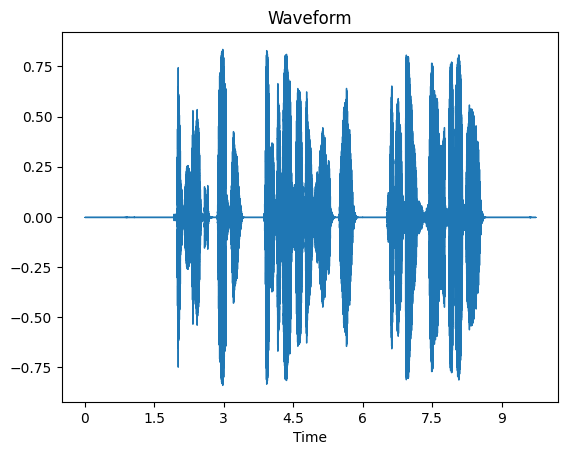

In [ ]:
plt.figure()
librosa.display.waveshow(ori_y1, sr=sr1)
plt.title('Waveform')
plt.show()

In [ ]:
# 무음을 제외한 구간 추출

intervals1 = librosa.effects.split(ori_y1, top_db=30)
intervals1

array([[ 31232,  43520],
       [ 45056,  54784],
       [ 61440,  86016],
       [ 87040,  93696],
       [103936, 137728]])

In [ ]:
# 추출한 구간으로 재구성

y1 = np.concatenate([ori_y1[start:end] for start, end in intervals1])
y1.shape

(87040,)

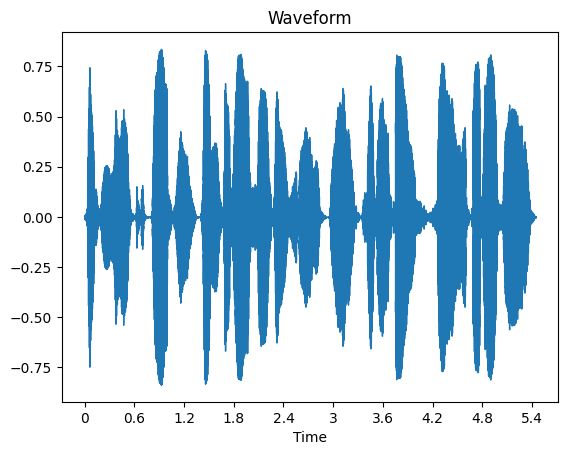

In [ ]:
plt.figure()
librosa.display.waveshow(y1, sr=sr1)
plt.title('Waveform')
plt.show()

In [ ]:
# Short-time Fourier transform
# shape: (주파수 축, 시간 축)

D1 = librosa.stft(y1)
D1.shape

(1025, 171)

In [ ]:
# 음량 -> 진폭
# np.abs(D): 각 주파수 성분의 진폭(magnitude)
# librosa.amplitude_to_db(): 사람이 인지 가능한 상대적인 음량 (볼륨) 표현 (dB X)
# S_db = 20 * log10(S / ref) : S는 진폭 스펙트럼
#                              ref는 기준값 → np.max(S)이면 가장 큰 소리를 0dB로, 나머지는 상대값
#                              이로 인해 모든 값은 음수이고, 0 dB는 가장 큰 진폭

S_db1 = librosa.amplitude_to_db(np.abs(D1), ref=np.max)
S_db1.shape

(1025, 171)

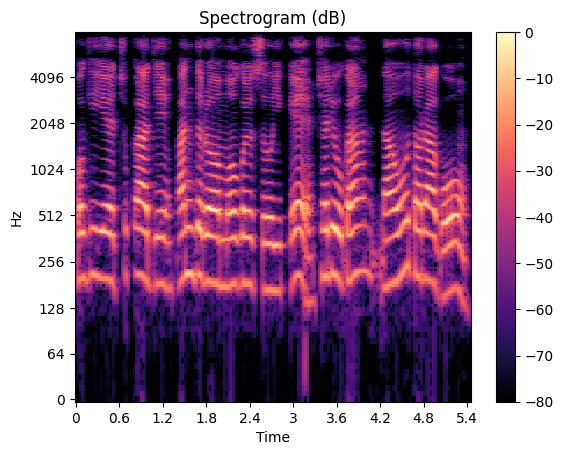

In [ ]:
plt.figure()
librosa.display.specshow(S_db1, sr=sr1, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Spectrogram (dB)')
plt.show()

In [ ]:
# Mel-Scale 변환

mel_spec1 = librosa.feature.melspectrogram(y=y1, sr=sr1, n_mels=128)
mel_spec1.shape

(128, 171)

In [ ]:
# dB로 변환

mel_db1 = librosa.power_to_db(mel_spec1, ref=np.max)
mel_db1.shape

(128, 171)

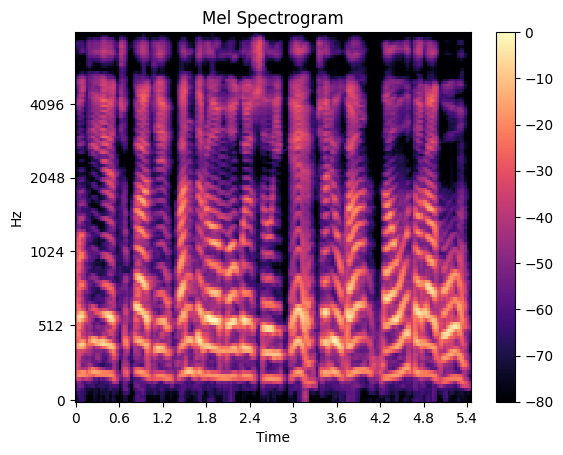

In [ ]:
plt.figure()
librosa.display.specshow(mel_db1, sr=sr1, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram')
plt.show()

In [ ]:
mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=13)
mfcc1.shape

(13, 171)

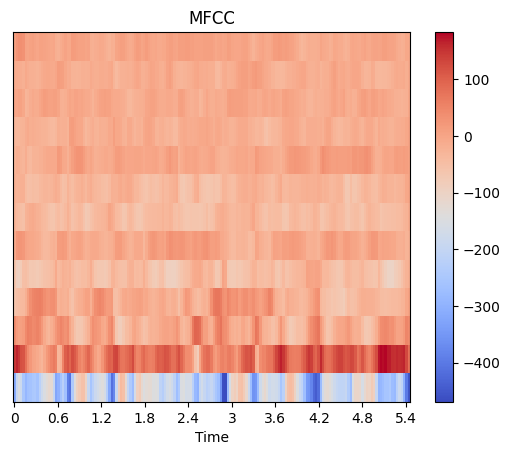

In [ ]:
plt.figure()
librosa.display.specshow(mfcc1, sr=sr1, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

# path_info 생성

In [ ]:
# 저는 작업할때 하나의 폴더에 같은 이름으로 .wav와 .json으로 음성파일과 메타데이터 파일을 넣어놨습니다.
# ex) 노인남여_노인대화07_F_1522434093_60_경상_실내_08580.wav / 노인남여_노인대화07_F_1522434093_60_경상_실내_08580.json

In [ ]:
json_list = glob.glob('/content/drive/Othercomputers/내 컴퓨터/pick/*.json')
json_list.sort()
len(json_list)

27535

In [ ]:
wav_list = glob.glob('/content/drive/Othercomputers/내 컴퓨터/pick/*.wav')
wav_list.sort()
len(wav_list)

27535

In [ ]:
# wav, json 정렬 확인
for json_file, wav in zip(json_list, wav_list):
  if json_file.split('.json')[0] != wav.split('.wav')[0]:
    print(json_file, wav)

In [ ]:
len(wav_list), len(json_list)

(27535, 27535)

In [ ]:
# 음성파일 경로와 음성의 전사 반환하는 함수
def load_one(file_name):
    with open(file_name, 'rb') as f:
        data = orjson.loads(f.read())
    return str(Path(file_name).with_suffix('.wav')), data["발화정보"]["stt"]  # with_suffix: 확장자를 변경해주는 메소드 / .json을 .wav로 변경

In [ ]:
# 병렬처리로 작업하는 함수
with ThreadPoolExecutor(max_workers=16) as ex:
    results = list(tqdm(ex.map(load_one, json_list), total=len(json_list)))

100%|██████████| 27535/27535 [19:59<00:00, 22.96it/s]


In [ ]:
# 음성파일 경로와 전사된 문장 DataFrame으로 저장 후 재사용 위해 csv로 저장
path_info = pd.DataFrame(results, columns=["path", "transcript"])
path_info.to_csv('/content/drive/MyDrive/Sesac/한상훈과아이들/path_info.csv', index=False)

# path_info 파일이 있다면 여기서부터

In [ ]:
path_info = pd.read_csv('your_pathe/path_info.csv')

In [ ]:
# 음성데이터 경로, 샘플링레이트, 멜변환차원수 변수로 넣어 멜변환해주는 함수
def audio_preprocess(wav, sr=16000, n_mels=128):
  ori_y1, sr1 = librosa.load(wav, sr=sr)
  mel_spec1 = librosa.feature.melspectrogram(y=ori_y1, sr=sr1, n_mels=n_mels)
  mel_db1 = librosa.power_to_db(mel_spec1, ref=np.max)
  with open(wav, 'rb') as f:
    wav_data = f.read()
  bytes_per_sample = 2
  duration = len(wav_data) / (sr * bytes_per_sample)

      # 멜변환된 데이터, 음성데이터길이(분,초), 음성데이터길이(STFT 개수)
  return mel_db1, round(duration, 3), mel_db1.shape[1]

In [ ]:
n_mels = 80  # 설정하고자 하는 멜변환 차원 수
sr = 16000  # 설정하고자 하는 샘플링레이트
sr_param = [sr] * len(wav_list)
mel_param = [n_mels] * len(wav_list)

In [ ]:
# 병렬처리로 작업하는 함수
with ThreadPoolExecutor(max_workers=16) as ex:
    audio_pair_data = list(tqdm(ex.map(audio_preprocess, wav_list, sr_param, mel_param), total=len(wav_list)))

100%|██████████| 27535/27535 [20:41<00:00, 22.18it/s]


In [ ]:
# 멜변환된 데이터, 음성데이터길이(분,초), 음성데이터길이(STFT 개수) DataFrame으로 저장
wav_info = pd.DataFrame(audio_pair_data, columns=['wav_data', 'duration', 'wav_length'])

In [ ]:
# json파일에 있는 문장 추출 후 토큰화 및 문장길이 반환
def script_preprocess(json_file):
  with open(json_file, 'r') as f:
    json_data = json.load(f)
    script = json_data['발화정보']['stt']
    seq = decompose_hangul(json_data['발화정보']['stt'])
    seq_2_id = [jamo_to_index[j] for j in seq if j in jamo_to_index]

      # 전사 문장, 토큰화된 문장, 문장길이
  return script, seq_2_id, len(seq_2_id)

In [ ]:
# 병렬처리로 작업하는 함수
with ThreadPoolExecutor(max_workers=16) as ex:
    scr_pair_data = list(tqdm(ex.map(script_preprocess, json_list), total=len(json_list)))

100%|██████████| 27535/27535 [00:27<00:00, 1010.80it/s]


In [ ]:
# 전사 문장, 토큰화된 문장, 문장길이 DataFrame으로 저장
seq_info = pd.DataFrame(scr_pair_data, columns=['script', 'seq', 'seq_length'])

In [ ]:
# 정리된 데이터들 확인
len(path_info),len(wav_info),len(seq_info)

(27535, 27535, 27535)

In [ ]:
# 10초 미만의 음성만 사용하기 위해 필터링
print(wav_info.loc[wav_info['duration']>10].index)

path_info.drop(wav_info.loc[wav_info['duration']>10].index,inplace=True)
seq_info.drop(wav_info.loc[wav_info['duration']>10].index,inplace=True)
wav_info.drop(wav_info.loc[wav_info['duration']>10].index,inplace=True)

path_info.reset_index(drop=True,inplace=True)
seq_info.reset_index(drop=True,inplace=True)
wav_info.reset_index(drop=True,inplace=True)

Index([  666,  2975,  5002,  5228,  5876,  7206,  8778,  9310, 15496, 20175,
       20181, 20204, 20320, 20335, 20365, 21852],
      dtype='int64')


In [ ]:
# 필터링 후 데이터 확인
len(path_info),len(wav_info),len(seq_info)

(27519, 27519, 27519)

In [ ]:
# 음성데이터 최대길이 설정
# 기본값으로 멜변환된 10초길이의 데이터가 312라서 저는 312로 했습니다.
wav_max_len = 312

In [ ]:
# 제가 설계한 모델에서 음성데이터의 1/2로 예측이 출력되서 이렇게 설정했습니다.
seq_max_len = int(wav_max_len/2)
seq_max_len

156

In [ ]:
# 모델에 들어갈 수 있는 최대 길이 초과된 데이터 , 전사 안에 특수토큰 있는 문장 필터링
print(seq_info.loc[(seq_info['seq_length']>seq_max_len) | (seq_info['script'].str.contains(r'[()]'))].index)

path_info.drop(seq_info.loc[(seq_info['seq_length']>seq_max_len) | (seq_info['script'].str.contains(r'[()]'))].index,inplace=True)
wav_info.drop(seq_info.loc[(seq_info['seq_length']>seq_max_len) | (seq_info['script'].str.contains(r'[()]'))].index,inplace=True)
seq_info.drop(seq_info.loc[(seq_info['seq_length']>seq_max_len) | (seq_info['script'].str.contains(r'[()]'))].index,inplace=True)

path_info.reset_index(drop=True,inplace=True)
wav_info.reset_index(drop=True,inplace=True)
seq_info.reset_index(drop=True,inplace=True)

Index([], dtype='int64')


In [ ]:
# 필터링 후 데이터 확인
len(path_info),len(wav_info),len(seq_info)

(27519, 27519, 27519)

In [ ]:
# 전처리된 path, script 정보 csv로 저장
path_info.to_csv('/content/drive/MyDrive/Sesac/한상훈과아이들/pre_path_t312_m80_s156.csv', index=False)

In [ ]:
# 패딩 작업 전 데이터 복사
b_pad_wav = wav_info['wav_data']
b_pad_seq = seq_info['seq']

In [ ]:
# 음성데이터 패딩 함수
def wav_padding(wav, wav_max_len=312):
  pad_width = wav_max_len - wav.shape[1]  # 얼마나 채워야 하는지
  if pad_width > 0:
      # 오른쪽(열 끝)에 0을 채움: ((행 시작, 행 끝), (열 시작, 열 끝))
      padded = np.pad(wav, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
  elif pad_width < 0:
      padded = wav[:,:pad_width]
  else:
      padded = wav  # 이미 가장 김
  return padded

In [ ]:
# 병렬처리로 작업하는 함수
with ThreadPoolExecutor(max_workers=16) as ex:
    audio_padded_data = list(tqdm(ex.map(wav_padding, b_pad_wav), total=len(b_pad_wav)))

100%|██████████| 27519/27519 [00:00<00:00, 70638.90it/s] 


In [ ]:
# 문장데이터 패딩 함수
def scr_padding(scr, seq_max_len=156):
  pad_width = seq_max_len - len(scr)  # 얼마나 채워야 하는지
  if pad_width > 0:
      # 오른쪽(열 끝)에 0을 채움: ((행 시작, 행 끝), (열 시작, 열 끝))
      for _ in range(pad_width):
        scr.append(0)
  return scr

In [ ]:
# 병렬처리로 작업하는 함수
with ThreadPoolExecutor(max_workers=16) as ex:
    scr_padded_data = list(tqdm(ex.map(scr_padding, b_pad_seq), total=len(b_pad_seq)))

100%|██████████| 27519/27519 [00:00<00:00, 479947.49it/s]


In [ ]:
# 패딩된 데이터 변수에 numpy배열로 변수에 담기
x_padded_data = np.stack(audio_padded_data)
x_data = np.transpose(x_padded_data, (0, 2, 1))
x_data_length = wav_info['wav_length'].to_numpy()

y_data = np.stack(scr_padded_data)
y_data_length = seq_info['seq_length'].to_numpy()

In [ ]:
# shape 확인
x_data.shape, y_data.shape, x_data_length.shape, y_data_length.shape

((27519, 312, 80), (27519, 156), (27519,), (27519,))

In [ ]:
# 재사용을 위한 데이터 저장
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/x_data_your_name.npy', x_data)
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/y_data_your_name.npy', y_data)
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/x_data_length_your_name.npy', x_data_length)
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/y_data_length_your_name.npy', y_data_length)

# numpy 파일이 있다면 여기서부터

In [ ]:
path_info = pd.read_csv('your_path/pre_path_your_name.csv')

In [ ]:
x_data = np.load('your_path/x_data_your_name.npy')
y_data = np.load('your_path/y_data_your_name.npy')
x_data_length = np.load('your_path/x_data_length_your_name.npy')
y_data_length = np.load('your_path/y_data_length_your_name.npy')

In [ ]:
path_info, x_data.shape, y_data.shape, x_data_length.shape, y_data_length.shape

((9170, 312, 128), (9170, 78), (9170,), (9170,))

In [ ]:
max_wav_len = x_data.shape[1]
max_seq_len = max_wav_len/2